In [1]:
#1

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os

import numpy as np
from tqdm.auto import tqdm
import glob

import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import PackedSequence

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

from Scripts.DetectNeuronVariance import standard_deviation_calc, calculate_high_low, write_altered_csv

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
#2

class Model(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=512, n_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.5
        )

        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        if isinstance(x, PackedSequence):
            packed_output, (hidden, _) = self.lstm(x)
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, (hidden, _) = self.lstm(x)

        output = self.classifier(output)
        return output

In [3]:
#3

"""
Dataset Selection

- Selects which folder of datasets will be used to train
- Also specifies which dataset will be withheld from the training data in order to be used in testing

Usage:
    trainingFiles, testFile = data_selection(n2_PreletandLet, testFileName)

    - First argument must specify the folder path. Has been set up so that user can swap names, choose between:
        - n2_PreletandLet
        - AVAandWTStim
    - Second argument must specify the name of the file that will be tested, choices include:
    NOTE: **IMPORTANT** Specified test file must be in the SAME folder as passed in the first argument
        - If AVAandWTStim:
            - AVA_HisCl1-5
            - WT_Stim1-7
        - If n2_PreletandLet:
            - n2_let1-12
            - n2_prelet1-11

Arguments:
    datasetPath: Specifies the folder that will be used. Each folder contains many datasets
    testDatasetName: Specifies the test file

Returns:
    newTrainingFiles: List containing all training files
    testDataPath: Path to the test file
"""

#Select which dataset you want to run through training
AVAandWTStim = os.path.join('.', 'DatasetsTest', 'AVA&WTStim', '*.csv')
n2_PreletandLet = os.path.join('.', 'DatasetsTest', 'n2_Prelet&Let', '*.csv')

#Choose one of the options above as first option which selects training data
#Then select a spcific dataset by name and input so that it can be specified as the test dataset

def data_selection(datasetPath, testDatasetName):
    csv_files = glob.glob(datasetPath)
    
    testDataPath = ""
    for i in range(len(csv_files)):
        if testDatasetName in csv_files[i]:
            testDataPath = csv_files[i]
            break
            
    newTrainingFiles = [trainFile for trainFile in csv_files if trainFile != testDataPath]
        
    return newTrainingFiles, testDataPath

#Select which specific csv file you want to run through the test
testFileName = "WT_Stim1" #Action needed
trainingFiles, testFile = data_selection(AVAandWTStim, testFileName) #Action Needed
print(trainingFiles)
print(testFile)

['.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl1.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl2.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl3.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl4.csv', '.\\DatasetsTest\\AVA&WTStim\\AVA_HisCl5.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim2.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim3.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim4.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim5.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim6.csv', '.\\DatasetsTest\\AVA&WTStim\\WT_Stim7.csv']
.\DatasetsTest\AVA&WTStim\WT_Stim1.csv


In [4]:
#4

max_features = 0

#Was used in some of the earlier iterations to calculate max feature length and pad files
#Since data processing is done in another file, function has been made redundant
#Kept in the final model in order act as a check to ensure all files are same length, and to set up the maxFeatures variable to create model instance with variable input size
for csv_file in trainingFiles:
    df = pd.read_csv(csv_file)
    X = df.drop('Action', axis=1).values
    max_features = max(max_features, X.shape[1])
    print(X.shape[1])

134
134
134
134
134
134
134
134
134
134
134


In [5]:
#5

def collate_fn(batch):
    sequences, labels, lengths = zip(*batch)
    lengths = torch.tensor([len(s) for s in sequences])
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_padded = pad_sequence(labels, batch_first=True)
    return sequences_padded, labels_padded, lengths

trainDatasets = []

for csv_file in trainingFiles:
    df = pd.read_csv(csv_file)
    X = df.drop('Action', axis=1).values
    y = df['Action'].values - 1
    
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    lengths = torch.full((len(y),), fill_value=X.shape[0])

    trainDatasets.append((X, y, lengths))

trainLoader = DataLoader(trainDatasets, batch_size=32, shuffle=True, collate_fn=collate_fn)



In [6]:
#6

"""
Train LSTM model

Trains the model on the established dataset

Usage:
    Press the play button

Arguments:
    Can choose to play around with the number of epochs
    

Returns:
    model: Creates a saved version of the model in the Saved_Models folder if line is uncommented
    NOTE: Must uncomment the line because the current models in Saved_Models are all from experimentation, must not be overridden
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_classes = 4
model = Model(max_features, n_classes, n_hidden=256, n_layers=3)
model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

nepochs = 150
trainingLoss = []
for epoch in range(nepochs):
    for i, (sequences, labels, lengths) in enumerate(trainLoader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        sequences = sequences.view(-1, sequences.shape[1], max_features)
        packed_sequences = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)

        optimizer.zero_grad()
        #outputs = model(packed_sequences)
        outputs = model(sequences)

        outputs = outputs.view(-1, outputs.shape[-1])  
        labels = labels.view(-1)  

        loss = criterion(outputs.view(-1, n_classes), labels.view(-1))
        loss.backward()
        optimizer.step()


    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, nepochs, loss.item()))
    trainingLoss.append(loss.item())
Path = os.path.join('.', 'Saved_Models', testFileName)
#Uncomment line below to start saving models
#torch.save(model, Path)


Epoch [1/150], Training Loss: 1.3878
Epoch [2/150], Training Loss: 1.3848
Epoch [3/150], Training Loss: 1.3819
Epoch [4/150], Training Loss: 1.3789
Epoch [5/150], Training Loss: 1.3760
Epoch [6/150], Training Loss: 1.3729
Epoch [7/150], Training Loss: 1.3699
Epoch [8/150], Training Loss: 1.3670
Epoch [9/150], Training Loss: 1.3638
Epoch [10/150], Training Loss: 1.3606
Epoch [11/150], Training Loss: 1.3573
Epoch [12/150], Training Loss: 1.3539
Epoch [13/150], Training Loss: 1.3504
Epoch [14/150], Training Loss: 1.3467
Epoch [15/150], Training Loss: 1.3429
Epoch [16/150], Training Loss: 1.3390
Epoch [17/150], Training Loss: 1.3346
Epoch [18/150], Training Loss: 1.3302
Epoch [19/150], Training Loss: 1.3254
Epoch [20/150], Training Loss: 1.3202
Epoch [21/150], Training Loss: 1.3147
Epoch [22/150], Training Loss: 1.3088
Epoch [23/150], Training Loss: 1.3023
Epoch [24/150], Training Loss: 1.2951
Epoch [25/150], Training Loss: 1.2875
Epoch [26/150], Training Loss: 1.2787
Epoch [27/150], Train

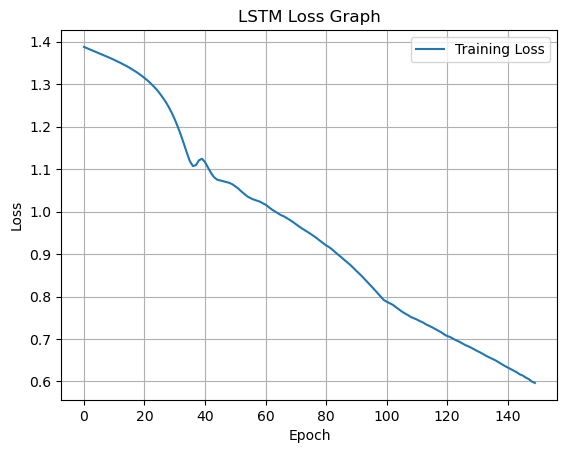

In [7]:
#7

import matplotlib.pyplot as plt

plt.plot(trainingLoss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss Graph')
plt.grid()
plt.legend()
plt.show()

In [8]:
#8

"""
Output Neurons w/ Largest and Smallest levels of variation

- Implemented in this Jupyter Notebook file to make it easier on anyone who might be running this code
- Core functions used are in a seperate file called DetectNeuronVariance.py, which is imported into this file

Usage:
    Press play on both cells

Arguments:
    testFile: The very same test file that was declared in the first cell of this notebook file

Returns:
    df: Returns a dataframe object of the test dataset to be used in testing that has not been altered in any way
    dfHigh: Returns a dataframe object with top 10 neurons having highest levels of standard deviation are replaced with zeroes
    dfLow: Returns a dataframe object with top 10 neurons having lowest levels of standard deviation are replaced with zeroes

Prints:
    Top 10 Neurons with Largest and Smallest levels of standard deviation, the exact same ones that were removed from their
    respective returned datasets
"""

df = pd.read_csv(testFile)

In [9]:
#9

stand_dev = standard_deviation_calc(df)

high10, low10 = calculate_high_low(stand_dev)

write_altered_csv(df, high10, low10, testFileName)

testFileHigh = os.path.join('.', 'TestData', testFileName + '_LargestRemoved.csv')

testFileLow = os.path.join('.', 'TestData', testFileName + '_SmallestRemoved.csv')

dfHigh = pd.read_csv(testFileHigh)

dfLow = pd.read_csv(testFileLow)

Largest:

1. (0.45324834350365056, 'RIML')
2. (0.3929122729053901, 'AVAL')
3. (0.3040725545901182, 'RIMR')
4. (0.27800514245678964, 'AIBL')
5. (0.23516075217370008, 'VB02')
6. (0.23085410715742746, 'VB01')
7. (0.2269168754857392, 'VA01')
8. (0.2144744892245799, 'AIBR')
9. (0.2088064217310758, 'RIVL/AVHL/AVJL')
10. (0.20274082611524713, 'ALA')



Smallest:

1. (0.025107501686762276, '[]_21')
2. (0.025304604156263153, '[]_17')
3. (0.025456893719213967, '[]_38')
4. (0.027023935680729857, '[]')
5. (0.027903430941009784, '[]_39')
6. (0.028003579321293468, '[]_47')
7. (0.028260956712249777, '[]_29')
8. (0.028449866210136593, '[]_14')
9. (0.028521795255345764, '[]_59')
10. (0.028886712645540106, '[]_27')


In [10]:
#10

"""
Predict Behavior using the trained or a saved model

- Casts predictions for the three dataframes that were established above: df, dfHigh, dfLow. Or as they are called in the paper: Vanilla, Largest, and Smallest

Usage:
    predictions = predict_actions(model, unlabeled_data, seq_length=10)

Arguments:
    model: The trained model. This can be a saved model that has been trained by me which are located in the Saved_Models folder or
    it can be the model that has been trained in context 

    unlabaled_data: test dataset that no longer possesses the 'Action' column which denotes current behavior
    
    seq_length: The context window that will be used to cast predictions. Aids in the implementation of the sliding window. 

Returns:
    predictions: Predictions for the given testdataset
"""

def predict_actions(model, dataset, seq_length=10):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #Comment out torch.load if running model that has not been saved and run in context
    model = model.to(device)
    model.eval()  
    predictions = []

    for i in range(seq_length, len(dataset)):
        sequence = torch.tensor(dataset[i-seq_length:i], dtype=torch.float32).unsqueeze(0).to(device) 
        output = model(sequence)  
        outLastStep = output[0, -1, :]
        _, predicted = torch.max(outLastStep.data, 0)
        predictions.append(predicted.item() + 1)
    return predictions

count = 0
predictPathVanilla = os.path.join('.', 'Predictions', 'predictions_' + testFileName + '.csv')
predictPathLargest = os.path.join('.', 'Predictions', 'predictions_' + testFileName + '_Highest.csv')
predictPathSmallest = os.path.join('.', 'Predictions', 'predictions_' + testFileName + '_Lowest.csv')

Path = os.path.join('.', 'Saved_Models', testFileName)
model = torch.load(Path)
while count < 3:
    if count == 0:
        unlabeled_data = df.drop('Action', axis=1).values
        predictions = predict_actions(model, unlabeled_data, seq_length=10)

        dfPredictions = pd.DataFrame({"Predicted_Action": [None]*10 + predictions})

        dfPredictions.to_csv(predictPathVanilla, index=False)
        count += 1

    if count == 1:
        unlabeled_data = dfHigh.drop('Action', axis=1).values
        predictions = predict_actions(model, unlabeled_data, seq_length=10)

        dfPredictions = pd.DataFrame({"Predicted_Action": [None]*10 + predictions})

        dfPredictions.to_csv(predictPathLargest, index=False)
        count += 1

    if count == 2:
        unlabeled_data = dfLow.drop('Action', axis=1).values
        predictions = predict_actions(model, unlabeled_data, seq_length=10)

        dfPredictions = pd.DataFrame({"Predicted_Action": [None]*10 + predictions})

        dfPredictions.to_csv(predictPathSmallest, index=False)
        count += 1



c:\Users\alino\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


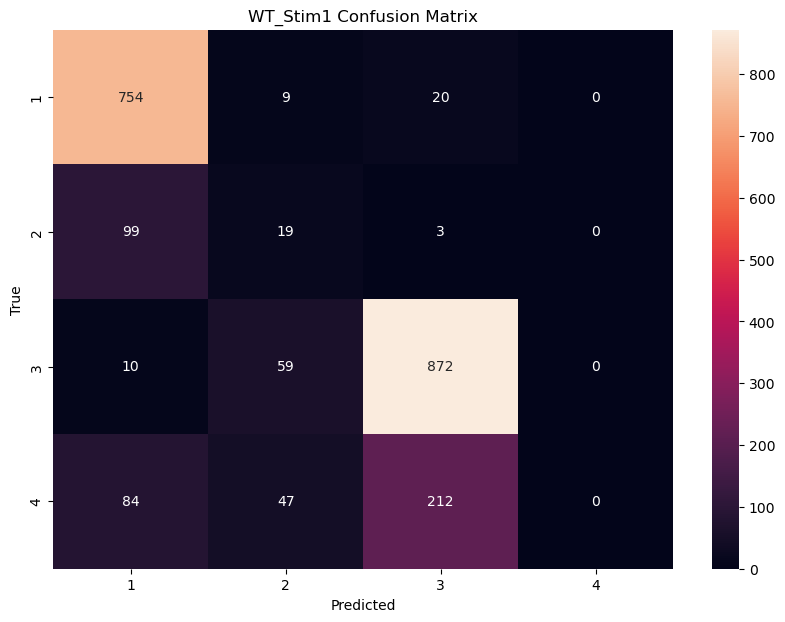

Accuracy: 75.18%
Precision: 63.15%
F1 Score: 68.64%




c:\Users\alino\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


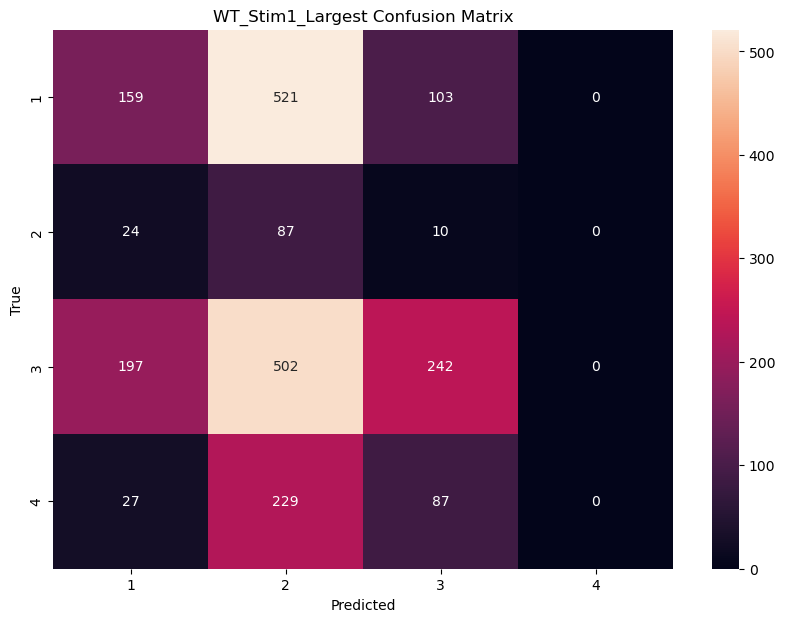

Accuracy: 22.30%
Precision: 37.89%
F1 Score: 25.27%




c:\Users\alino\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


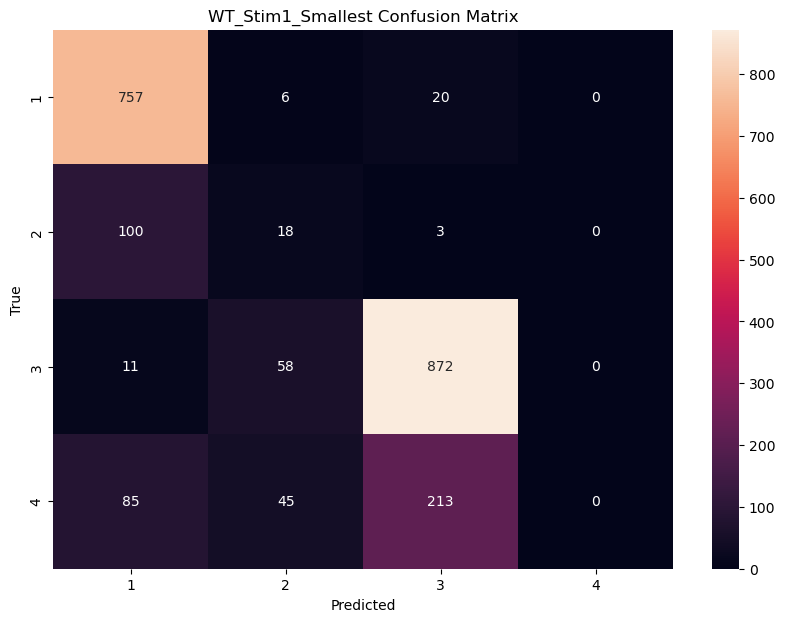

Accuracy: 75.27%
Precision: 63.06%
F1 Score: 68.62%


In [11]:
#11

"""
Compares the predictions cast by the model with the true labels

Usage:
    accuracy, confusion_mat, precision, f1 = compare_predictions(trueDF, predictedDF)

Arguments:
    trueDF: The test dataset with the action column in place
    predictedDF: The output of the predict_actions function

Returns:
    accuracy: The accuracy of the predictions compared to the true labels 
    cm: Confusion matrix of the predictions and true labels
    precision: The precision of the predictions compared to the true labels
    f1: The f1 score of the predictions compared to the true labels
"""

def compare_predictions(trueDF, predictedDF):
    count = 0
    total = 0

    trueDF = trueDF.iloc[10:]
    predictedDF = predictedDF.iloc[10:]

    cmTrueLabels = []
    cmPredictedLabels = []

    for trueLabel, predictedLabel in zip(trueDF['Action'], predictedDF['Predicted_Action']):
        total += 1
        cmTrueLabels.append(trueLabel)
        cmPredictedLabels.append(predictedLabel)
        if trueLabel == predictedLabel:
            count += 1

    accuracy = count / total
    cmTrueLabels = [value + 1 for value in cmTrueLabels]
    cmPredictedLabels = [value + 1 for value in cmPredictedLabels]
    cm = confusion_matrix(cmTrueLabels, cmPredictedLabels)

    precision = precision_score(cmTrueLabels, cmPredictedLabels, average='weighted')
    f1 = f1_score(cmTrueLabels, cmPredictedLabels, average='weighted')

    return accuracy, cm, precision, f1

trueDF = df

#Vanilla
predictedDF = pd.read_csv(predictPathVanilla)
accuracy, confusion_mat, precision, f1 = compare_predictions(trueDF, predictedDF)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])


plt.title(testFileName + ' Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\n")

#Largest
predictedDF = pd.read_csv(predictPathLargest)
accuracy, confusion_mat, precision, f1 = compare_predictions(trueDF, predictedDF)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title(testFileName + '_Largest' + ' Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\n")

#Smallest
predictedDF = pd.read_csv(predictPathSmallest)
accuracy, confusion_mat, precision, f1 = compare_predictions(trueDF, predictedDF)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])

plt.title(testFileName + '_Smallest' + ' Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')